In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from string import punctuation

from typing import Dict, Union, List, Optional
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from dataclasses import dataclass
from functools import lru_cache

from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook

sw_indo = list(stopwords.words('indonesian') + list(punctuation))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [29]:
df = pd.read_csv("/content/MLBB Reviews.csv")
# resample to make df same length with df before
len_df_before = 4440
df = df.sample(len_df_before)
# Parse date and sort ascending
df['date'] = pd.to_datetime(df['date'], format="%d %B %Y", errors="coerce")
df = df.sort_values(by='date')
df.head()

(4440, 4)


# Preprocessing

In [8]:
class Preprocessor:
    def __init__(self):
        self.stemmer = StemmerFactory().create_stemmer()
        self.tokenizer = word_tokenize
        self.stopwords = sw_indo

    def lowercasing(self, text: str) -> str:
        """Mengubah text menjadi lowercase dengan penanganan error"""
        if not isinstance(text, str):
            if pd.isna(text):
                return ""
            text = str(text)
        return text.lower()

    def stemming(self, text: str) -> str:
        """Melakukan stemming dengan penanganan error"""
        if not text:
            return ""
        try:
            return self.stemmer.stem(text)
        except Exception as e:
            print(f"Warning: Error pada stemming '{text[:50]}...': {str(e)}")
            return text

    def tokenize(self, text: str) -> List[str]:
        """Melakukan tokenisasi dengan penanganan error"""
        if not text:
            return []
        try:
            return self.tokenizer(text)
        except Exception as e:
            print(f"Warning: Error pada tokenisasi '{text[:50]}...': {str(e)}")
            return text.split()

    def remove_stopwords(self, tokens: List[str]) -> List[str]:
        """Menghapus stopwords dengan penanganan error"""
        if not tokens:
            return []
        try:
            return [word for word in tokens if word not in self.stopwords]
        except Exception as e:
            print(f"Warning: Error pada remove stopwords: {str(e)}")
            return tokens

    def fit(self, text: str, concate: bool = False) -> Union[List[str], str]:
        """
        Melakukan preprocessing lengkap dengan penanganan error di setiap tahap

        Args:
            text: Text yang akan dipreprocess
            concate: Jika True, mengembalikan string. Jika False, mengembalikan list

        Returns:
            Text yang sudah dipreprocess dalam bentuk string atau list
        """
        try:
            if pd.isna(text):
                return "" if concate else []

            X = self.lowercasing(str(text))
            X = self.stemming(X)
            X = self.tokenize(X)
            X = self.remove_stopwords(X)

            if concate:
                X = " ".join(X) if X else ""

            return X
        except Exception as e:
            print(f"Warning: Error pada preprocessing '{str(text)[:50]}...': {str(e)}")
            return "" if concate else []

# Sentiment Classification

In [9]:
@dataclass
class SentimentConfig:
  """ Konfiguasi untuk Model Sentimen Analisis """
  model_id: str = "mdhugol/indonesia-bert-sentiment-classification"
  labels: Dict[str, str] = None

  def __post_init__(self):
    if self.labels is None:
      self.labels = {
          "LABEL_0": "positif",
          "LABEL_1": "netral",
          "LABEL_2": "negatif"
      }

In [21]:
class IndoBERTSentimentAnalyzer:
    def __init__(self, config: Optional[SentimentConfig] = None):
        self.config = config or SentimentConfig()
        self._initialize_model()

    def _initialize_model(self) -> None:
        try:
            self.model = AutoModelForSequenceClassification.from_pretrained(self.config.model_id)
            self.tokenizer = AutoTokenizer.from_pretrained(self.config.model_id)
            self.sentiment_pipe = pipeline(
                "sentiment-analysis",
                model=self.model,
                tokenizer=self.tokenizer
            )
        except Exception as e:
            raise RuntimeError(f"Gagal memuat model IndoBERT: {str(e)}")

    @lru_cache(maxsize=1024)
    def analyze(self, text: str) -> str:
        if not isinstance(text, str):
            if pd.isna(text):
                return "netral"
            text = str(text)

        text = text.strip()
        if not text:
            return "netral"

        try:
            result = self.sentiment_pipe(text)
            return self.config.labels[result[0]["label"]]
        except Exception as e:
            return "netral"

    def analyze_dataframe(
        self,
        df: pd.DataFrame,
        text_column: str,
        output_column: str = "sentiment",
        batch_size: int = 32
    ) -> pd.DataFrame:
        if text_column not in df.columns:
            raise ValueError(f"Kolom '{text_column}' tidak ditemukan dalam DataFrame")

        result_df = df.copy()

        # Menggunakan tqdm untuk progress bar
        tqdm.pandas(desc="Analyzing sentiments")
        result_df[output_column] = df[text_column].progress_apply(self.analyze)

        return result_df

In [30]:
preprocessor = Preprocessor()
analyzer = IndoBERTSentimentAnalyzer()

# Preprocessing
df["comment_prep"] = df["comment"].apply(lambda x: preprocessor.fit(x, concate=True))

result_df = analyzer.analyze_dataframe(df, "comment_prep")
result_df.head()

Device set to use cuda:0


Analyzing sentiments:   0%|          | 0/4440 [00:00<?, ?it/s]

,name,date,star,comment,comment_prep,sentiment
3471,Bocil Oyen,2024-09-01,1,"Ada jg perbaiki system matching nya, bukan bag...",jg system matching nya skin gratis dark system...,positif
3494,Raffa Al Fatir,2024-09-01,5,"menurut saya udah bagus, efek skin sekarang ud...",udah bagus efek skin udah keren keren banget k...,positif
3961,yusuf Nugroho,2024-09-01,1,saya kasih bintang 1 karena banyak nya drak si...,kasih bintang 1 nya drak sistem menggangu play...,negatif
3569,Tegar Gar,2024-09-01,1,game yang tidak pantas untuk di donlot karena ...,game donlot alas 1 ngasih lawan ngga tara team...,negatif
3730,M. Rahman,2024-09-01,1,Tolong di perbaiki lagi bug sinyal nya gimana ...,tolong bug sinyal nya gimana sinyal wifi full ...,negatif


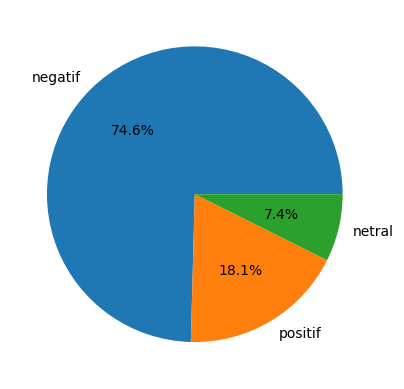

In [31]:
plt.pie(result_df.sentiment.value_counts(), labels=result_df.sentiment.value_counts().index, autopct='%1.1f%%')
plt.show()

In [32]:
result_df.to_csv("MLBB Reviews Processed.csv", index=False)

In [26]:
result_df.shape[0]

4440

# Exploratory Data Analysis

In [ ]:
print(f"Data ini diambil dari tanggal {df.date.min().strftime('%d %B %Y')} sampai {df.date.max().strftime('%d %B %Y')}")

Data ini diambil dari tanggal 01 September 2024 sampai 30 November 2024


Rata-rata star: 2.17 



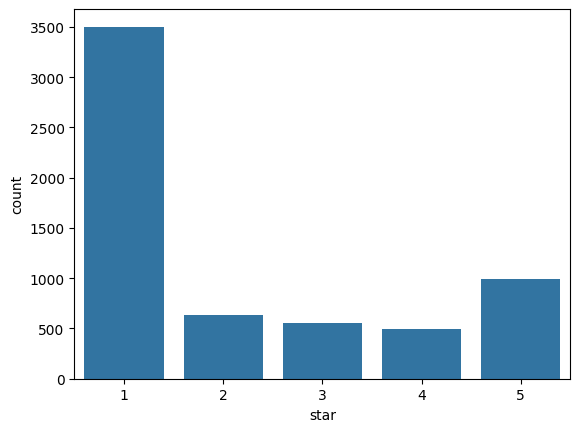

In [ ]:
# Count Plot + avarage in star column
sns.countplot(data=df, x="star")
print(f"Rata-rata star: {df.star.mean():.2f} \n")